In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns


In [10]:
sign_dict = {
  "trafficlight": 1,
  "stop": 2,
  "speedlimit": 3,
  "crosswalk": 4,

  "['trafficlight', 'trafficlight']": 1,
  "['stop', 'stop']": 2,
  "['speedlimit', 'speedlimit']": 3,
  "['crosswalk', 'crosswalk']": 4,

  "['crosswalk', 'trafficlight']": 5,
  "['crosswalk', 'stop']": 6,
  "['crosswalk', 'speedlimit']": 7,
  "['speedlimit', 'trafficlight']": 8,
  "['speedlimit', 'stop']": 9,
  "['stop', 'trafficlight']": 10,

  "['trafficlight', 'trafficlight', 'trafficlight']": 1,
  "['stop', 'stop', 'stop']": 2,
  "['speedlimit', 'speedlimit', 'speedlimit']": 3,
  "['crosswalk', 'crosswalk', 'crosswalk']": 4,

  "['crosswalk', 'crosswalk', 'speedlimit']": 11,
  "['crosswalk', 'crosswalk', 'stop']": 12,
  "['crosswalk', 'crosswalk', 'trafficlight']": 13,
  "['crosswalk', 'speedlimit', 'speedlimit']": 14,
  "['crosswalk', 'speedlimit', 'trafficlight']": 15,
  "['crosswalk', 'stop', 'trafficlight']" :16,
  "['crosswalk', 'trafficlight', 'trafficlight']": 17,
  "['speedlimit', 'speedlimit', 'stop']": 18,
  "['speedlimit', 'speedlimit', 'trafficlight']": 19,
  "['stop', 'trafficlight', 'trafficlight']": 20


}

In [47]:
# Path to image and annotation directories
images = "/Users/favourokpali/Documents/Semester 2/ECE9022-Assignments/FinalProject/output_images/"
annotations = "/Users/favourokpali/Documents/Semester 2/ECE9022-Assignments/FinalProject/annotations/"

# Initialize empty lists for image data and labels
X_data = []
Y_data = []

check = []

# Set the desired image size (e.g., 256x256)
image_size = (256, 256)

# Iterate through images and annotations
for image_name in os.listdir(images):
    image_root_name = image_name.split('.')[0]
    
    for annotation_name in os.listdir(annotations):
        annotation_root_name = annotation_name.split('.')[0]
        
        # Match image and annotation by root name
        if annotation_root_name == image_root_name:
            annotation_path = os.path.join(annotations, annotation_name)
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            num_objects = len(root.findall("object"))

            if num_objects == 1:
                y_value = root[4][0].text
            elif num_objects == 2:
                y_value = sorted([root[4][0].text, root[5][0].text])
            elif num_objects == 3:
                y_value = sorted([root[4][0].text, root[5][0].text, root[6][0].text])

            # Read and resize the image to a consistent shape (e.g., 256x256)
            img_path = os.path.join(images, image_name)
            try:
                img = mpimg.imread(img_path)
                if img.shape[-1] == 3:  # Convert RGB → RGBA by adding an alpha channel
                    img = np.dstack((img, np.ones((img.shape[0], img.shape[1], 1))))  # Add alpha = 1 (fully opaque)
                elif img.shape[-1] == 1:  # Convert grayscale → RGBA
                    img = np.repeat(img, 3, axis=-1)  # Duplicate channels to make RGB
                    img = np.dstack((img, np.ones((img.shape[0], img.shape[1], 1))))  # Add alpha
                print(img)
                img_resized = image.smart_resize(img, image_size)  # Resize image to 256x256
                img_resized = np.ravel(img_resized)  # Flatten image data
                X_data.append(img_resized)
            except Exception as e:
                print(f"Error loading or resizing image {img_path}: {e}")
                continue  # Skip this image if it fails to load or resize

            # Parse annotation data (ensure proper indexing based on your XML structure)
            
            # Encode label based on the dictionary
            try:
                annotation_encoded = sign_dict[str(y_value)]
                Y_data.append(annotation_encoded)
            except KeyError:
                print(f"Warning: Label {y_value} not found in sign_dict. Skipping.")
                continue  # Skip this label if it is not found
            if y_value not in check:
                check.append(y_value)

# Convert to DataFrames
X_data = np.array(X_data)
Y_data = np.array(Y_data)
print(len(X_data), len(Y_data))

print(X_data.shape, Y_data.shape)

[[[0.80392158 0.89019608 0.85882354 1.        ]
  [0.78431374 0.84705883 0.9137255  1.        ]
  [0.95686275 0.98823529 1.         1.        ]
  ...
  [0.65882355 0.6901961  0.70588237 1.        ]
  [0.03921569 0.09411765 0.09019608 1.        ]
  [0.38431373 0.40392157 0.39215687 1.        ]]

 [[0.81568629 0.9137255  0.85490197 1.        ]
  [1.         1.         1.         1.        ]
  [0.73725492 0.82352942 0.87058824 1.        ]
  ...
  [0.40000001 0.39607844 0.42745098 1.        ]
  [0.19607843 0.19215687 0.22352941 1.        ]
  [0.2        0.23529412 0.23137255 1.        ]]

 [[1.         1.         1.         1.        ]
  [0.         0.         0.         1.        ]
  [1.         1.         1.         1.        ]
  ...
  [0.         0.         0.         1.        ]
  [0.58431375 0.63529414 0.61176473 1.        ]
  [0.43921569 0.45490196 0.4627451  1.        ]]

 ...

 [[0.87843138 1.         1.         1.        ]
  [0.         0.         0.         1.        ]
  [0.     

In [44]:
X_data = X_data.reshape((X_data.shape[0], 512, 512, 1)) 
Y_data = Y_data.flatten()

print(Y_data.shape)
print(X_data.shape)

# Print unique values of Y_data to check the range
Y_data_encoded = to_categorical(Y_data, num_classes=21)

x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data_encoded, test_size=0.2, random_state=42)


(877,)
(877, 512, 512, 1)


In [45]:
# Build the CNN model
model = models.Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))  # Adjust input shape as necessary

# Add a max-pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Add another convolutional layer with 64 filters
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add another max-pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Add a flatten layer to flatten the 2D matrix into 1D
model.add(layers.Flatten())

# Add a fully connected (dense) layer with 128 neurons and ReLU activation
model.add(layers.Dense(128, activation='relu'))

# Output layer with 20 neurons (one for each class) and softmax activation
model.add(layers.Dense(21, activation='softmax'))

# Compile the model with categorical cross-entropy loss, Adam optimizer, and accuracy metric
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print(f"Test Accuracy: {test_acc * 100:.2f}%")



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.4005 - loss: 41.3293 - val_accuracy: 0.6591 - val_loss: 2.3032
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.6933 - loss: 1.7964 - val_accuracy: 0.6591 - val_loss: 1.6061
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.6640 - loss: 1.4907 - val_accuracy: 0.6591 - val_loss: 1.5872
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.6711 - loss: 1.4672 - val_accuracy: 0.6591 - val_loss: 1.5363
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6612 - loss: 1.4493 - val_accuracy: 0.6591 - val_loss: 1.5422
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6705 - loss: 1.3461 - val_accuracy: 0.6591 - val_loss: 1.4307
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.6513 - loss: 1.3518 - val_accuracy: 0.6591 - val_loss: 1.4202
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6537 - loss: 1.3522 - val_accuracy: 0.6591 - val_loss

In [48]:
y_pred = model.predict(x_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 754ms/step


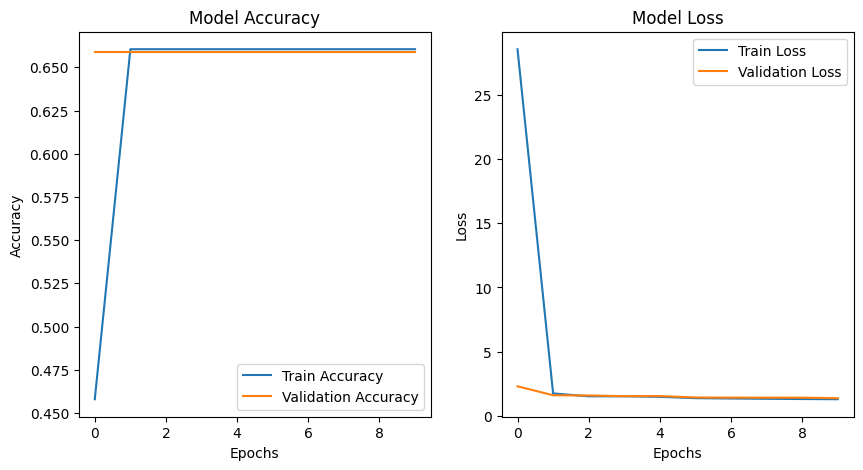

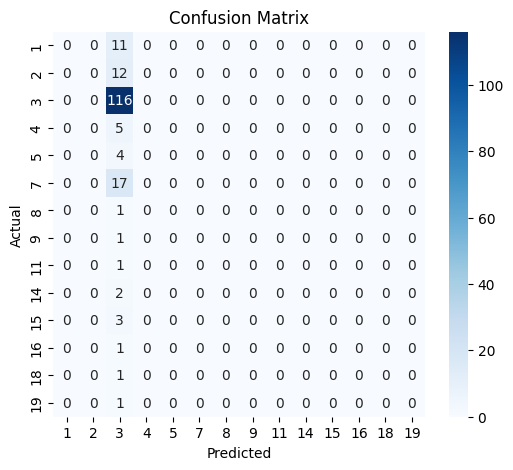

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWa

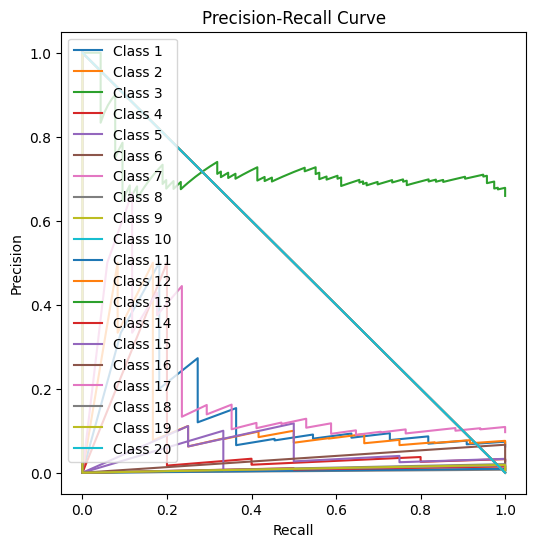

In [50]:

# 1. Accuracy vs. Loss Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. Confusion Matrix
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot to label format
y_pred_classes = np.argmax(y_pred, axis=1)  # If multi-class
cm = confusion_matrix(y_test_labels, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_labels), yticklabels=np.unique(y_test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4. Precision-Recall Curve
plt.figure(figsize=(6, 6))
for i in range(1, y_test.shape[1]):  # Loop through each class
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()

